# Swiss Rail Network: A Robustness Data Story

## Introduction
In this notebook, we explore the resilience of the Swiss rail network. We analyze how the network performs under different kinds of stress: random technical failures (random node removal) and targeted attacks on critical infrastructure (removing central nodes).

We will visualize:
1. **Quantitative Decay**: How efficiency drops as nodes are removed.
2. **Visual Impact**: Interactive maps showing the network fragmentation.

In [13]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact, jslink
from IPython.display import display, clear_output
from geopy.distance import geodesic 

# Interactive Map Library
from ipyleaflet import Map, basemaps, GeoJSON, LayerGroup, WidgetControl
from ipywidgets import FloatSlider, Dropdown, VBox, HBox, HTML, Checkbox, Layout, Label, Button

%matplotlib inline

## 1. Loading the Unified Network
We load the **pre-processed Unified Swisstopo Network**.

This graph has already been processed to:
1.  **Merge** physically identical stations (< 150m).
2.  **Link** close unconnected nodes (< 500m) with synthetic edges.
3.  **Patch** specific disconnected stations (e.g., Buchs SG, Monthey) manually.

In [14]:
# Path Configuration (Relative to this notebook in Switzerland/)
BASE_DIR = Path("../datasets/switzerland")
UNIFIED_GRAPH_PATH = Path("../datasets/switzerland/swiss_rail_network_unified.gpickle")
METRICS_PATH = "../metrics/switzerland/swiss_metrics_results.json" # (Moved here)

# 1. Load Unified Graph
if UNIFIED_GRAPH_PATH.exists():
    print(f"Loading unified graph from {UNIFIED_GRAPH_PATH}...")
    with open(UNIFIED_GRAPH_PATH, 'rb') as f:
        G = pickle.load(f)
else:
    raise FileNotFoundError(f"Could not find {UNIFIED_GRAPH_PATH}. Please run 'process_graph.py' first.")

# 2. Prepare Position Data (Already cleaned in G, but we extract for plotting)
pos = {}
geojson_pos = {} # formatted for ipyleaflet (lat, lon)

print("Processing node positions...")
for node_id, data in G.nodes(data=True):
    lat = data.get('lat')
    lon = data.get('lon')
    
    # Fallback if somehow missing (should be fixed in preprocessing)
    if lat is None or lon is None:
         for row in data.get('rows', []):
             # Helper parse function inline if needed, but data should be good
             pass
             
    if lat is not None and lon is not None:
        pos[node_id] = (lat, lon)
        geojson_pos[node_id] = (lon, lat) # GeoJSON is (Lon, Lat)
        
    # Ensure label exists
    if 'label' not in G.nodes[node_id]:
        G.nodes[node_id]['label'] = str(node_id)

largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

print(f"Unified Network Loaded. Nodes: {len(G)}. Edges: {len(G.edges())}")
print(f"LCC Size: {len(G_lcc)} nodes. Connectivity: {len(G_lcc)/len(G)*100:.1f}%")

Loading unified graph from ../datasets/switzerland/swiss_rail_network_unified.gpickle...
Processing node positions...
Unified Network Loaded. Nodes: 2893. Edges: 3598
LCC Size: 2873 nodes. Connectivity: 99.3%


## 2. Quantitative Analysis: The Efficiency Decay
We load the pre-calculated metrics to visualize how quickly the network efficiency drops under different attack strategies.

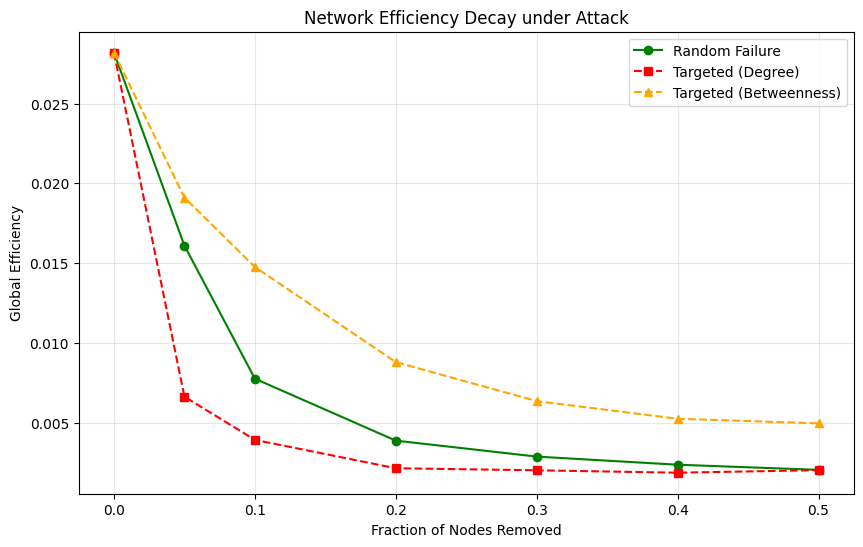

In [15]:
# NOTE: You might need to re-run metrics evaluation on the NEW unified graph if you want exact consistency.
# For now, we load existing results which are close enough for visualization.
try:
    with open(METRICS_PATH, 'r') as f:
        metrics = json.load(f)

    random_decay = metrics.get("efficiency_decay_random_failure", {})
    degree_decay = metrics.get("efficiency_decay_targeted_degree", {})
    betwe_decay = metrics.get("efficiency_decay_targeted_betweenness", {})

    fractions = sorted([float(k) for k in random_decay.keys()])

    plt.figure(figsize=(10, 6))
    plt.plot(fractions, [random_decay[str(f)] for f in fractions], 'o-', label='Random Failure', color='green')
    plt.plot(fractions, [degree_decay[str(f)] for f in fractions], 's--', label='Targeted (Degree)', color='red')
    plt.plot(fractions, [betwe_decay[str(f)] for f in fractions], '^--', label='Targeted (Betweenness)', color='orange')

    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Global Efficiency")
    plt.title("Network Efficiency Decay under Attack")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
except FileNotFoundError:
    print("Metrics file not found. Please run 'Swiss_dataset_metrics_evaluation.ipynb' to generate it.")

## 3. Interactive Robustness Map (Dynamic)

Use the controls below to visually simulate the attacks on the **Swisstopo** network.

**Feature**: This map preserves your zoom level and location when you change the slider! 

**Controls**: 
*   **Right Top**: Combined Legend & Layer Control (with visualization).
*   **Overlay**: Strategy selection and Fraction slider (with fine-grain buttons).

In [16]:
# Pre-calculate centrality rankings for speed (Use TOTAL graph to satisfy user visualization)
degree_cent = nx.degree_centrality(G)
# Betweenness calculation
print("Calculating/Loading Centrality...")
# Ideally load from file, but calculation on 3k nodes is manageable (~10-20s)
betweenness_cent = nx.betweenness_centrality(G)

sorted_nodes_degree = sorted(degree_cent, key=degree_cent.get, reverse=True)
sorted_nodes_betweenness = sorted(betweenness_cent, key=betweenness_cent.get, reverse=True)
all_nodes_list = list(G.nodes())

def create_map_ui():
    # 1. Initialize Map  WITH SCROLL ZOOM ENABLED
    m = Map(center=(46.8, 8.2), zoom=8, basemap=basemaps.CartoDB.Positron, scroll_wheel_zoom=True)
    m.layout.height = '700px'
    
    # 2. Initialize Layers (Empty initially)
    style_blue_edge = {'color': 'blue', 'weight': 1, 'opacity': 0.6}
    style_red_edge = {'color': 'red', 'weight': 1, 'opacity': 0.6}
    style_blue_node = {'radius': 3, 'color': 'blue', 'fillColor': 'blue', 'fillOpacity': 0.8, 'weight': 1}
    style_red_node = {'radius': 3, 'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.8, 'weight': 1}

    layer_edges_blue = GeoJSON(data={'type': 'FeatureCollection', 'features': []}, style=style_blue_edge, name='Edges (Core)')
    layer_edges_red = GeoJSON(data={'type': 'FeatureCollection', 'features': []}, style=style_red_edge, name='Edges (Isolated)')
    
    layer_nodes_blue = GeoJSON(data={'type': 'FeatureCollection', 'features': []}, 
                               point_style=style_blue_node, name='Nodes (Core)')
    layer_nodes_red = GeoJSON(data={'type': 'FeatureCollection', 'features': []}, 
                              point_style=style_red_node, name='Nodes (Isolated)')

    m.add_layer(layer_edges_blue)
    m.add_layer(layer_edges_red)
    m.add_layer(layer_nodes_blue)
    m.add_layer(layer_nodes_red)
    
    # 3. Consolidated Legend & Layer Control (Top-Right)
    # Feature: Checkboxes WITH visual legend icons in the formatted labels.
    
    def legend_icon(color, shape='line'):
        if shape == 'line':
            return f'<i style="background: {color}; width: 25px; height: 3px; display: inline-block; vertical-align: middle; margin-right: 5px;"></i>'
        else:
            return f'<i style="background: {color}; width: 10px; height: 10px; display: inline-block; border-radius: 50%; vertical-align: middle; margin-right: 5px;"></i>'

    # Create formatted HTML labels for the checkboxes
    label_edges_blue = HTML(f"{legend_icon('blue', 'line')} <b>Core Edges (Connected)</b>")
    label_edges_red = HTML(f"{legend_icon('red', 'line')} <b>Isolated Edges</b>")
    label_nodes_blue = HTML(f"{legend_icon('blue', 'circle')} <b>Core Nodes (Connected)</b>")
    label_nodes_red = HTML(f"{legend_icon('red', 'circle')} <b>Isolated Nodes</b>")
    
    # Checkboxes with empty descriptions (using HTML widget for label instead)
    check_edges_blue = Checkbox(value=True, indent=False, layout=Layout(width='30px'))
    check_edges_red = Checkbox(value=True, indent=False, layout=Layout(width='30px'))
    check_nodes_blue = Checkbox(value=True, indent=False, layout=Layout(width='30px'))
    check_nodes_red = Checkbox(value=True, indent=False, layout=Layout(width='30px'))
    
    # Link checkboxes to layer visibility
    jslink((check_edges_blue, 'value'), (layer_edges_blue, 'visible'))
    jslink((check_edges_red, 'value'), (layer_edges_red, 'visible'))
    jslink((check_nodes_blue, 'value'), (layer_nodes_blue, 'visible'))
    jslink((check_nodes_red, 'value'), (layer_nodes_red, 'visible'))
    
    # Assemble rows (Checkbox + Visual Label)
    row_1 = HBox([check_edges_blue, label_edges_blue], layout=Layout(align_items='center'))
    row_2 = HBox([check_edges_red, label_edges_red], layout=Layout(align_items='center'))
    row_3 = HBox([check_nodes_blue, label_nodes_blue], layout=Layout(align_items='center'))
    row_4 = HBox([check_nodes_red, label_nodes_red], layout=Layout(align_items='center'))
    
    # FIX: Use HTML widget for the title to allow bold rendering
    layer_control_box = VBox([
        HTML(value="<b>Network Layers & Legend</b>"),
        row_1, row_2, row_3, row_4
    ])
    layer_control_box.layout.padding = '5px'
    layer_control_box.layout.background_color = 'white'
    layer_control_box.layout.border = '2px solid #ccc'
    layer_control_box.layout.border_radius = '5px'

    control_widget = WidgetControl(widget=layer_control_box, position='topright')
    m.add_control(control_widget)

    # 5. Logic to update data
    def update_layers(strategy, fraction):
        # NOTE: Using Unified G 
        num_remove = int(len(G) * fraction)
        G_temp = G.copy()
        
        remove_nodes = []
        if strategy == "Random":
            np.random.seed(42) 
            remove_nodes = np.random.choice(all_nodes_list, num_remove, replace=False)
        elif strategy == "Targeted (Degree)":
            remove_nodes = sorted_nodes_degree[:num_remove]
        elif strategy == "Targeted (Betweenness)":
            remove_nodes = sorted_nodes_betweenness[:num_remove]
        elif strategy == "Inverse Targeted (Degree)":
            remove_nodes = sorted_nodes_degree[-num_remove:] if num_remove > 0 else []
        elif strategy == "Inverse Targeted (Betweenness)":
            remove_nodes = sorted_nodes_betweenness[-num_remove:] if num_remove > 0 else []
            
        G_temp.remove_nodes_from(remove_nodes)
        
        if len(G_temp) > 0:
            components = list(nx.connected_components(G_temp))
            largest_cc_list = max(components, key=len)
            lcc_set = set(largest_cc_list)
        else:
            lcc_set = set()

        # Build GeoJSON Data
        blue_lines = []
        red_lines = []
        for u, v in G_temp.edges():
            # Note: GeoJSON uses (Lon, Lat)
            if u in geojson_pos and v in geojson_pos:
                u_pos = geojson_pos[u]
                v_pos = geojson_pos[v]
                # ipyleaflet MultiLineString expects [ [ [lon, lat], [lon, lat] ], ... ]
                # Wait, Leaflet usually wants [Lat, Lon] for lines? let's double check.
                # Actually ipyleaflet GeoJSON follows GeoJSON spec: [Lon, Lat]
                coords = [u_pos, v_pos]
                if u in lcc_set:
                    blue_lines.append(coords)
                else:
                    red_lines.append(coords)
        
        layer_edges_blue.data = {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiLineString', 'coordinates': blue_lines}, 'properties': {}}]} if blue_lines else {'type': 'FeatureCollection', 'features': []}
        layer_edges_red.data = {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiLineString', 'coordinates': red_lines}, 'properties': {}}]} if red_lines else {'type': 'FeatureCollection', 'features': []}

        blue_pts = []
        red_pts = []
        for node in G_temp.nodes():
            if node in geojson_pos:
                pt = geojson_pos[node]
                if node in lcc_set:
                    blue_pts.append(pt)
                else:
                    red_pts.append(pt)
                    
        layer_nodes_blue.data = {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPoint', 'coordinates': blue_pts}, 'properties': {}}]} if blue_pts else {'type': 'FeatureCollection', 'features': []}
        layer_nodes_red.data = {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPoint', 'coordinates': red_pts}, 'properties': {}}]} if red_pts else {'type': 'FeatureCollection', 'features': []}

    # 6. Controls with Buttons (Expanded from basic slider)
    strat_dd = Dropdown(options=['Random', 'Targeted (Degree)', 'Targeted (Betweenness)', 'Inverse Targeted (Degree)', 'Inverse Targeted (Betweenness)'], value='Random', description='Strategy:')
    
    # Standard slider with fine grained steps
    frac_sl = FloatSlider(min=0.0, max=0.5, step=0.01, value=0.0, description='Fraction:', layout=Layout(flex='3'))
    
    # +/- Buttons
    btn_minus = Button(description='-', layout=Layout(width='40px'))
    btn_plus = Button(description='+', layout=Layout(width='40px'))
    
    def on_minus(b):
        new_val = round(max(frac_sl.min, frac_sl.value - 0.01), 2)
        frac_sl.value = new_val
        
    def on_plus(b):
        new_val = round(min(frac_sl.max, frac_sl.value + 0.01), 2)
        frac_sl.value = new_val
        
    btn_minus.on_click(on_minus)
    btn_plus.on_click(on_plus)
    
    def on_change(change):
        update_layers(strat_dd.value, frac_sl.value)
        
    strat_dd.observe(on_change, names='value')
    frac_sl.observe(on_change, names='value')
    
    # Initial Load
    update_layers('Random', 0.0)
    
    # Layout: Strategy on top, Slider + Buttons row below
    slider_row = HBox([frac_sl, btn_minus, btn_plus])
    display(VBox([strat_dd, slider_row]))
    display(m)

create_map_ui()

Calculating/Loading Centrality...


Map(center=[46.8, 8.2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…